##### AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<center>
    <h1 style = "font-size:48px; font-weight:normal"><b>AI</b>-TECH</style></h1>
    <br>
<br>
<br>
<br>
    <h1 style = "font-size:24px; font-weight:normal">Przykład 1 DO LABORATORIUM 3</style></h1>
    <h1 style = "font-size:24px">z UCZENIA MASZYNOWEGO</style></h1>
    <h1 style = "font-size:24px">Klasyfikacja nienadzorowana</style></h1>
    <h1 style = "font-size:24px">Adam Kurowski</style></h1>
    <h3 style = "font-size:21px">Klasyfikacja nadzorowana i nienadzorowana bazująca na metrykach odległości</h3>
    <h3 style = 
</center>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
    </body>
    </html>

![stopka.svg](stopka.svg)

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

<hr>

# Przykład 1.: Klasyfikacja nadzorowana i nienadzorowana bazująca na metrykach odległości


## Analiza struktury danych wejściowych

Klasyfikacja nienadzorowana to technika przydatna w sytuacji, gdy nie nie mamy pełnej informacji o strukturze danych, które przetwarzamy. Możemy na przykład jedynie wiedzieć, ile klas danych występuje, jednak nie mamy pełnej informacji o tym, które dokładnie elementy zbioru danych należą do konkretnych klas. 

Jest to sytuacja wymagająca specyficznego podejścia do zadania klasyfikacji i podjęcia próby przypisania do poszczególnych klas zbiorów danych wyróżniających się w jakiś specyficzny sposób z ogółu zbioru danych. Jedną z najprostszych technik mogących wykonać tak zdefiniowane zadanie jest algorytm *k* średnich (ang. *k* means), który jest co do swojej zasady działania nieco podobny do algorytmu *k* najbliższych sąsiadów (ang. *k* nearest neighbours, kNN). Obydwa te algorytmy w swoim najprostszym wariancie posługują się odległością euklidesową pomiędzy punktami (lub pomiędzy punktami, a środkami klastrów) do zdefiniowania przynależności przetwarzanych punktów danych do konkretnej klasy. W tym zadaniu zapoznamy się z obydwoma algorytmami. Zaczniemy od zagadnienia znanego już z poprzednich ćwiczeń - algorytmu *k* najbliższych sąsiadów.

In [11]:
# Import bibliotek
import numpy  as np # obliczenia numeryczne
import pandas as pd # przetwarzanie danych "tabelarycznych"
import matplotlib.pyplot as plt # wizualizacja danych
from sklearn.datasets import load_iris # zbiór danych - wykorzystamy słynny zbiór Iris
from sklearn.decomposition import PCA # redukcja wymiarowości
from sklearn.neighbors import KNeighborsClassifier # implementacja algorytmu k najbliższych sąsiadów (kNN)
from sklearn.cluster import KMeans # implementacja algorytmu k średnich
from mlxtend.plotting import plot_decision_regions # wizualizacja obszarów decyzyjnych algorytmó k średnich i kNN

Do analizy wykorzystamy zbiór danych Iris, możemy łatwo pozyskać go za pomocą API udostępnianego przez bibliotekę scikit-learn.

In [12]:
# Załadowanie danych z wybranego zbioru danych
dataset_dict = load_iris()

# Wypisanie podstawowych informacji o danych pozyskanych poprzez API biblioteki scikit-learn.
print('Słownik przechowujący zbiór danych ma następujące klucze:')
print(list(dataset_dict.keys()))

print()
print('Do dyspozycji są następujące cechy:')
print(dataset_dict['feature_names'])

print()
print('Nazwy klas w zbiorze danych:')
print(dataset_dict['target_names'])

# Kilka kluczy ze słownika dla wygody wydzielimy do zmiennych:
data          = dataset_dict['data']
target        = dataset_dict['target']
target_names  = dataset_dict['target_names']

Słownik przechowujący zbiór danych ma następujące klucze:
['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename']

Do dyspozycji są następujące cechy:
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Nazwy klas w zbiorze danych:
['setosa' 'versicolor' 'virginica']


Dane pozyskane z API biblioteki scikit-learn mogą być przez nas dodatkowo normalizowane. Odpowiedni kod znajduje się poniżej. Na początku jednak pozostawmy dane w oryginalnej postaci i sprawdźmy, jak algorytmy radzą sobie bez tego dodatkowego kroku.

In [22]:
def norm_unit_absval(data):
    for i in range(data.shape[1]):
        data[:,i] = data[:,i]/np.max(np.abs(data[:,i]))
    return data

def norm_standardize(data):
    # raise(NotImplementedError('Funkcja do zaimplementowania przez wykonującego ćwiczenie.'))
    # stanadaryzacja -> próbka i - mena / deviation
    for i in range(data.shape[1]):
        data[:,i] = (data[:,i] - np.mean(data[:,i])) / np.std(data[:,i])
    return data

def norm_row_vector_length(data):
    for i in range(data.shape[1]):
        data[:,i] = data[:,i] / len((data[:,i]))
    return data

# Odkomentować, jeżeli normalizacja jest potrzebna:
# data = norm_unit_absval(data)
# data = norm_standardize(data)
data = norm_row_vector_length(data)

Dane po (opcjonalnym) etapie normalizacji możemy następnie wstępnie przeanalizować za pomocą szeregu technik. Wiele z nich zaimplementowanych jest w bibliotece Pandas, która zawiera wiele przydatnych narzędzi do pracy z danymi tabelarycznymi. Jest ona także specjalnie przystosowana do radzenia sobie ze zbiorami danych, w których występują brakujące wartości, czy takich zbiorach, dla których konieczna jest np. agregacja danych za okres miesiąca, czy roku. Stąd bardzo często widywana jest ona w skryptach realizujących zaawansowane analizy danych (np. w dziedzinach takich jak tzw. *data science*, czy *big data*).

Na potrzeby naszych analizy utworzymy podstawową strukturę danych wykorzystywaną w bibliotece Pandas, ramkę danych nazywaną DataFrame. Można ją sobie wyobrażać jak logiczną reprezentację arkusza programu takiego jak Microsoft Excel, czy Libre Office Calc. Składa się ona z nazwanych kolumn, w których możemy wpisywać dane.

In [23]:
# Tworzymy ramkę danych (obiekt DataFrame).
data_df         = pd.DataFrame(data)

# Chcemy, żeby kolumny ramki danych posiadały nazwy wskazane przez API.
data_df.columns = dataset_dict['feature_names']

# Dodatkowo dodajemy kolumnę z docelową nazwą klasy.
data_df         = data_df.assign(target = target)

# Pierwotnie nazwy klas w zmiennej target są zakodowane za pomocą liczb całkowitych, dlatego dla czytelności
# skonwertujemy je na nazwy opisowe. Jeżeli chcemy to zrobić na już utworzonej kolumnie w obiekcie DataFrame,
# to musimy ją "zaznaczyć".

# Możemy tego dokonać za pomocą specjalnego pola loc. Służy ono do wskazywania kolumn po nazwie, kolumny można też wskazywać
# poprzez ich całkowitoliczbowy indeks, do czego służy pole iloc. My chcemy wskazać wszystkie wartości kolumny 'target' 
# z ramki danych o nazwie data_df, co tłumaczy się na wywołanie w postaci data_df.loc[:,'target']. Przekazujemy wartość 
# tego wywołania do listy pozwalającej przedłumaczyć indeks na opisową nazwę klasy - target_names.

data_df.loc[:,'target']  = target_names[data_df.loc[:,'target']]

# Na koniec możemy wyświetlić podgląd danych znajdujących się w obiekcie DataFrame, przypomina on nawet nieco swym wyglądem
# klasyczny arkusz kalkulacyjny:
print(data_df)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0            -0.006005          0.006793          -0.008935         -0.008770   
1            -0.007620         -0.000880          -0.008935         -0.008770   
2            -0.009236          0.002189          -0.009314         -0.008770   
3            -0.010043          0.000655          -0.008556         -0.008770   
4            -0.006812          0.008328          -0.008935         -0.008770   
..                 ...               ...                ...               ...   
145           0.006920         -0.000880           0.005464          0.009659   
146           0.003689         -0.008553           0.004706          0.006149   
147           0.005304         -0.000880           0.005464          0.007026   
148           0.002881          0.005259           0.006222          0.009659   
149           0.000458         -0.000880           0.005085          0.005271   

        target  
0       se

Jednym z najprostszych sposobów jest tzw. wykres współrzędnych równoległych (ang. *parallel coordinates plot*), który polega na przedstawieniu wszystkich wymiarów przetwarzanego zbioru danych w postaci pionowych osi liczbowych. Następnie każdy punkt na takim zestawie osi przedstawiany jest w postaci łamanej, która składa się z wartości danego punktu danych przypisanych do każdej z osi. Działanie takie wykonuje się dla każdego punktu w zbiorze danych, a efekt jest taki, jak po wykonaniu poniższego kodu:

Text(0.5, 1.0, 'Wizualizacja za pomocą wykresu w układzie równoległych współrzędnych')

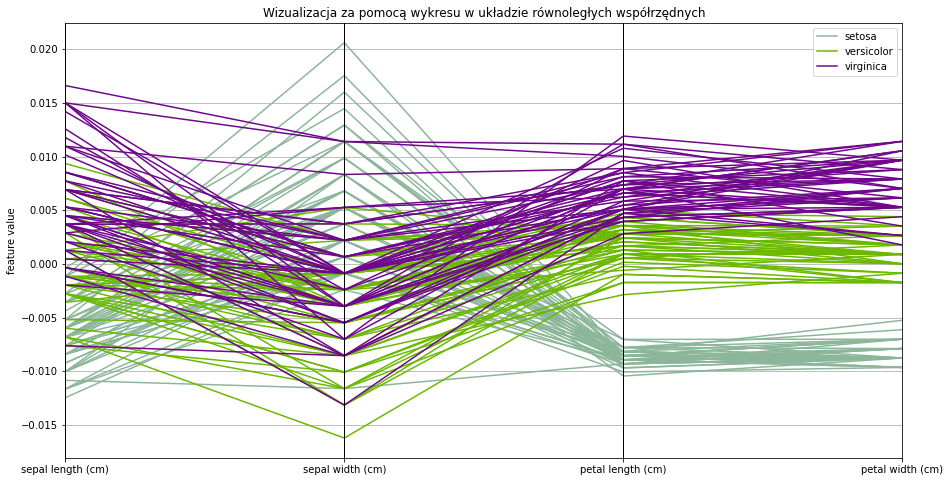

In [24]:
# Zdefiniowanie rozmiarów wykresu
plt.figure(figsize=(15,8))

# Biblioteka Pandas posiada już gotową funkcję rysującą wizualizację w układzie współrzędnych równoległych:
pd.plotting.parallel_coordinates(data_df, 'target')

# Na koniec dodajemy opis osi y i tytuł.
plt.ylabel('feature value')
plt.title('Wizualizacja za pomocą wykresu w układzie równoległych współrzędnych')

Zwizualizowanie z apomocą wykresu współrzędnych równoległych pozwala na zorientowanie się, czy występuje separacja pomiędzy poszczególnymi klasami danych i czy jest ona szczególnie zauważalna na którymś z wymiarów zbioru danych.

Dla zbioru Iris taka separazja pomiędzy klasą serosa i dwiema pozostałymi klasami jest szczególnie widoczna dla wymiarów *petal length* i *petal width*. Pewna separacja jest także widoczna pomiędzy klasami versicolor i virginica, jednak tutaj nie jest ona już taka silna i część skrajnych możliwych wartoścu obu klas nachodzi się na siebie. Najlepsza pod względem separacji między klasami versicolor i virginica jest kolumna danych *petal length*.

Warto zaznaczyć, że taki sposób wizualizacji pozwala w prosty sposób ocenić separowalność między klasami dla zbiorów danych o wysokiej wymiarowości. Wizualizacja danych np. za pomocą PCA wymaga utraty informacji, tutaj informacja ta jest zachowywana. Tracimy natomiast intuicyjność, gdyż wykres tego typu nie pozwala na ocenienie w prosty sposób odległości pomiędzy punktami. 

Wykorzystanie wykresu współrzędnych równoległych jest także przydatne w przypadku danych dla któych nie mamy żadnej informacji na temat występujących w nim klas - w przypadku zbioru Iris "rozdwojenie" wykresu sugeruje, że występują w nim przynajmniej dwie klasy obiektów.

Innym wykresem podobnym do wykresu współrzędnych równoległych jest zobrazowanie za pomocą tzw. krzywych Andrewsa lub wykresu Andrewsa. Nie jest on jednak aż tak łatwy do interpretacji. Nadal jednak pozwala ocenić np., czy struktura danych zdradza istnienie odseparowanych od siebie klastrów. Krzywe dla wykresu Andrewsa wylicza sie za pomocą następuującej zależności:

$f_{\mathbf{x}}(t) = \frac{x_1}{\sqrt{2}} + x_2 \sin(t) + x_3 \cos(t) + x_4 \sin(2t) + x_5 \cos(2t) + x_6 \sin(3t) + x_7 \cos(3t) + ...$,

gdzie $f_{\mathbf{x}}(t)$ to krzywa odpowiadająca punktowi danych $\mathbf{x} = (x_1,x_2,x_3, ...,x_n)$, a $t$ jest parametrem, który na wykresie oblicza się dla zakresu wartości $<-\pi;\pi>$. Przykład wykresu krzywych Andrewsa dla zbioru Iris można wygenerować za pomocą kodu poniżej:

Text(0.5, 1.0, 'Wizualizacja za pomocą krzywych Andrewsa')

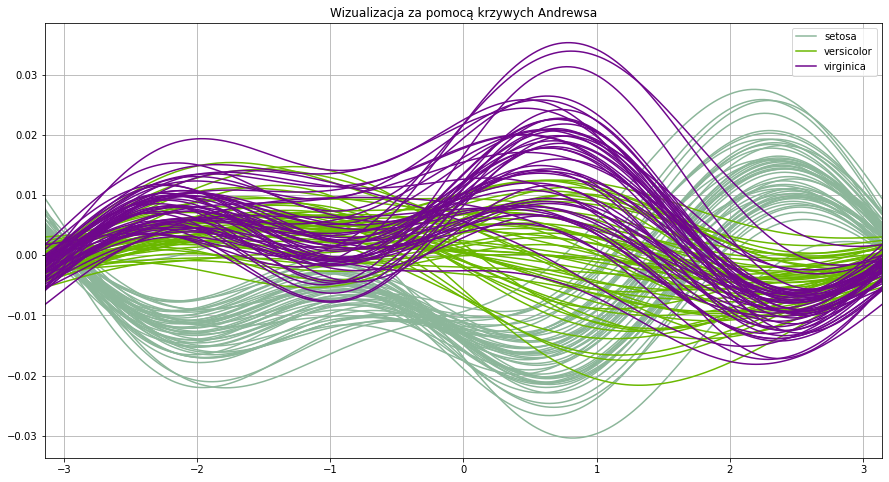

In [26]:
# Zdefiniowanie rozmiarów wykresu
plt.figure(figsize=(15,8))

# Biblioteka Pandas posiada także procedurę generującą wykres Andrewsa:
pd.plotting.andrews_curves(data_df, 'target')

# Dodajemy także tytuł...
plt.title('Wizualizacja za pomocą krzywych Andrewsa')

W przypadku wykresu krzywych Andrewsa i zbioru Iris także najsilniej odznacza się klasa setosa. Klasy versicolor i virginica są blisko siebie i bez kolorowania klas trudno by było zauważyć że stanowią one dwie odrębne klasy.

Oczywiście, możliwe jest także posłużenie się algorytmami redukcji wymiarowości do analizy struktury danych. Na potrzeby tego ćwiczenia wykorzystamy algorytm PCA i zredukujemy wymiarowość danych do 2 najważniejszych składowych.

In [27]:
# Obiekt algorytmu redukcji wymiarowości do 2 wymiarów.
pca = PCA(n_components=2)

# Efekt redukcji wymiarowości zapiszemy w osobnej zmiennej:
reduced_data = pca.fit_transform(data)

Posiadanie danych w postaci zredukowanej pozwala na ich prostą wizualizację w postaci dwuwymiarowego wykresu punktowego. Należy pamiętać, że każda redukcja wymiarowości wiąże się z utratą części pierwotnej informacji, dlatego należy tego typu wykresy traktować jedynie poglądowo. Wszelkie ostateczne analizy należy prowadzić w miarę możliwości w przestrzeni wysokowymiarowej. Pełnowymiarowej, jeżeli pozwalają na to zasoby obliczeniowej, lub zredukowanej do maksymalnej, możliwej, rozsądnie wysokiej liczby wymiarów. Pozwala to na ograniczanie strat informacji wynikających z faktu redukcji wymiarowości.

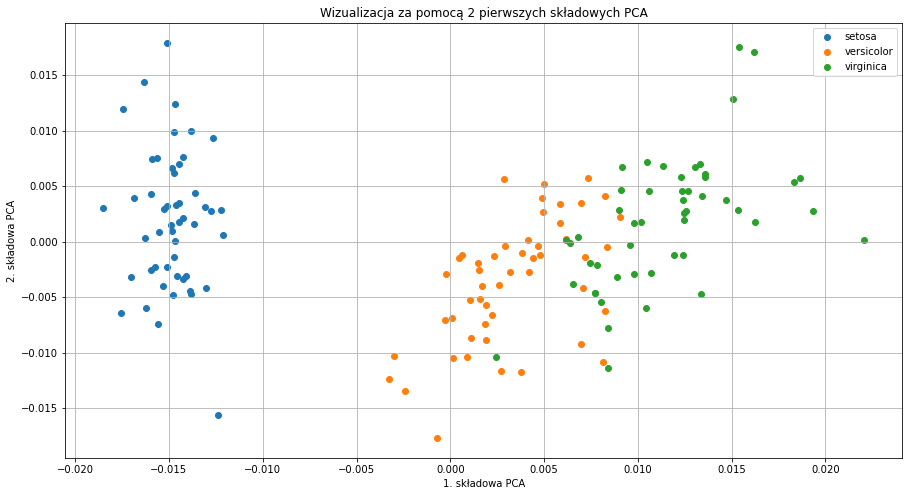

In [28]:
# Zdefiniowanie rozmiarów wykresu
plt.figure(figsize=(15,8))

# Opisujemy osie
plt.xlabel('1. składowa PCA')
plt.ylabel('2. składowa PCA')

# Narysujemy wykres punktowy. Rysujemy każdą klasę z osobna w pętli. Iterujemy po wszystkich dostępnych możliwych
# wartościach występujących w zmiennej target. 
for targ_val in np.unique(target):
    # Generujemy sobie maskę za pomocą której wybierzemy punkty należące do każdej z klas.
    mask = target==targ_val
    # Dla tak wszystkich punktów wybranych za pomocą odpowiadającej danej klasie maski rysujemy wykres punktowy.
    plt.scatter(reduced_data[mask,0],reduced_data[mask,1], label = target_names[targ_val])

# Na koniec dodajemy tytuł, legendę i rysujemy siatkę.
plt.title('Wizualizacja za pomocą 2 pierwszych składowych PCA')
plt.legend()
plt.grid()

Na wykresie także widoczny jest fakt, że to klasa setosa jest najlepiej separującą się klasą danych. Problemów z separacją możemy się spodziewać w przypadku klas versicolor i virginica, gdyż także w przypadku wizualizacji bazującej na algorytmie PCA klasy te są umiejscowione blisko siebie. 

## Klasyfikacja nadzorowana bazująca na metryce odległości euklidesowej <br/>(algorytm k najbliższych sąsiadów)

Baując na danych pozyskanych za pomocą algorytmu PCA zwizualizujemy sobie zasadę działania algorytmu kNN. Będziemy dokonywać klasyfikacji na danych zredukowanych.

<b>W praktyce unikalibyśmy takiego podejścia</b>, bo tracimy informację zawartą w pełnych 4 składowych zbioru Iris. Na potrzeby ćwiczenia jednak taki zabieg pozwoli nam na łatwe i intuicyjne zwizualizowanie granic decyzyjnych wygenerowanych przez algorytm, który klasyfikacji dokonuje poprzez zastosowanie następujących kroków:

<ol>
<li/>Dla klasyfikowanego punktu danych określ odległości do k najbliższych punktów danych, dla których klasa jest znana
<li/>Oblicz czętość występowania poszczególnych klas wśród k najbliższych punktów danych, dla których klasa jest znana
<li/>punkt powinien być zakwalifikowany do tej klasy, która jest najczęstsza wśród klas k najbliższych punktów wyznaczonych w kroku poprzednim.
</ol>

Efektem takiego postępowania jest utworzenie klasyfikatora charakteryzującego się krzywymi decyzyjnymi takimi, jak na rysunku będącym efektem wykonania kodu poniżej:


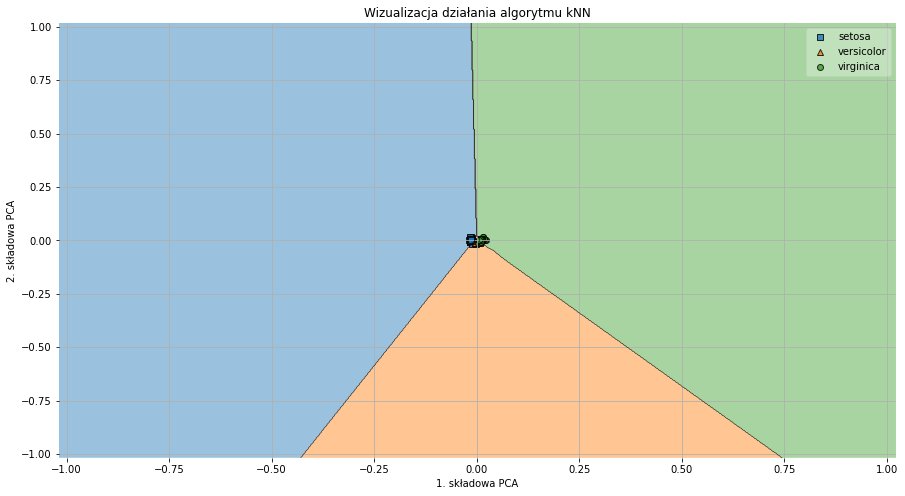

In [29]:
# Wybierzmy sobie wartość k, którą przechowywać będziemy w zmiennej o opisowej nazwie n_neighbors.
n_neighbors = 5
# Tworzymy klasyfikator dla wybranej liczby najbliższych sąsiadów.
kNN_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)

# Trenujemy klasyfikator dla otrzymanych danych i ich etykiet (klasyfikacja nadzorowana).
kNN_classifier.fit(reduced_data, target)

# Rysujemy wykres - najpierw definicja rozmiarów
plt.figure(figsize=(15,8))

# Następnie wykorzystujemy funkcję z pakietu mlxtend, która pozwala na wygodne narysowanie sobie 
# granic decyzyjnych klasyfikatora
ax = plot_decision_regions(reduced_data, target, clf=kNN_classifier)

# Opisujemy osie, dodajemy tytuł i siatkę.
plt.xlabel('1. składowa PCA')
plt.ylabel('2. składowa PCA')
plt.title('Wizualizacja działania algorytmu kNN')
plt.grid()

# Na koniec zmodyfikujemy jeszcze legendę. Bez tego podane w niej są jedynie indeksy klas, a nie ich
# opisowe nazwy. Dla czytelności zmienimy je za pomocą poniższych linijek na nazwy opisowe przechowywane
# w zmiennej target_names.
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, target_names, framealpha=0.3, scatterpoints=1)

## Klasyfikacja nienadzorowana bazująca na metryce odległości euklidesowej <br/>(algorytm k średnich)

Możemy nieco zmodyfikować rozumowanie wykorzystywane do zdefiniowania algorytmu k najbliższych sąsiadów i dostosować je do sytuacji, w której nie wiemy dokładnie, jak punkty są przydzielone do klas. Nadal wymagana będzie wiedza o tym, ile klas zawiera się w zbiorze danych.

Algorytm k średnich jest (podobnie jak algorytm kNN) możliwy do opisania w postaci krótkiej listy czynności. Na początku musimy przyjąć, jakiej liczby klastrów spodziewamy się w analizowanych danych (teraz to właśnie ją oznaczmy jako $k$).

<ol>
    <li/>Wybierz losowo $k$ punktów ze zbioru danych i wykorzystaj je jako początkowe centra klastrów. W praktyce często wykorzystywana jest tutaj metoda kmeans++, która pozwala na wybranie punktów w sposób możliwie zwiększający zbieżność algorytmu k średnich. Więcej szczegółów można przeczytać np. w publikacji <a href="http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf">D. Arthura i S. Vassilvitskiiego, p.t. "k-means++: The Advantages of Careful Seeding"</a>.
    <li id="return_instruction"/>Wykorzystaj tak wygenerowane centra klastrów by przypisać wszystkie punkty w zbiorze do klastra, którego centrum (zwane czasami centroidem) jest najbliżej. Czynność wykonywaną w ramach tego podpunktu jest tożsama z wykonaniem algorytmu kNN z liczbą sąsiadów równą 1 i centrami klastrów służącymi jako dane treningowe (najbliższe centrum decyduje o przynależności do klastra).
    <li/> Na podstawie tak wygenerowanych klastrów wylicza się nowe ich centra. Wystarczy do tego uśrednić współrzędne punktów w każdym klastrze.
    <li/> Jeżeli zmiana położenia klastrów jest mniejsza niż wybrany przez nas próg, np. $10^{-4}$, to przerywamy wykonanie algorytmu, podobnie jeżeli osiągnęliśmy maksymalną liczbę iteracji (np. 100).
    <li/> Jeżeli nie przerwaliśmy wykonania algorytmu w poprzednim kroku to wracamy do punktu 2..
</ol>

Można zatem powiedzieć, że logika działania algorytmu kNN jest podstawą dla algorytmu k średnich. Przykład jego użycia na aktualnie przetwarzanym zbiorze danych widoczny jest poniżej:

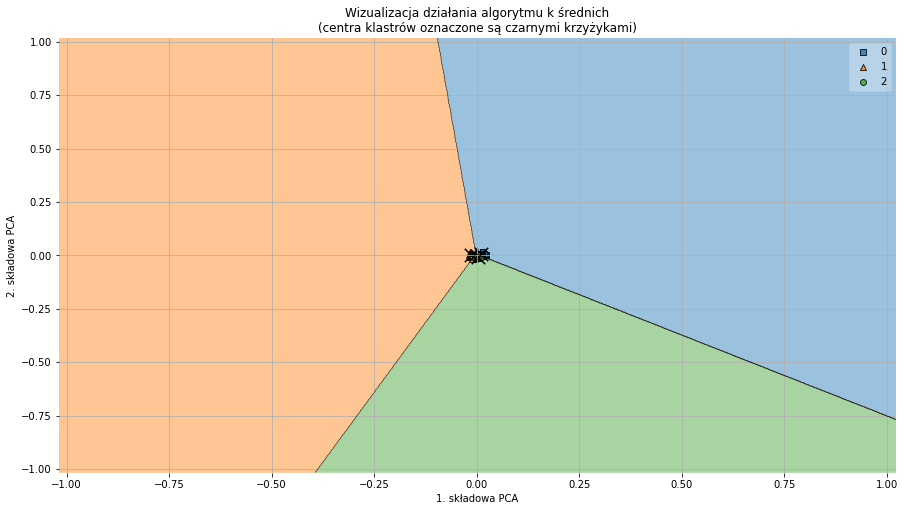

In [30]:
# Na początek zdefiniujmy kilka nastaw pracy algorytmu:
n_clusters      = 3    # Liczba klastrów, której się spodziewamy
n_init          = 1      # Scikit-learn pozwala wykonać algorytm kilkukrotnie i wybrać najlepsze rozwiązanie, 
                         # tutaj definiujemy ile razy obliczenia mają być powtórzone
num_iterations  = 100 # maksymalny limit iteracji algorytmu k średnich
tolerance       = 0.0001 # minimalna wartość, poniżej której uznajemy, że zmiany w położeniu klastrów już nie są istotne

# Definiujemy algorytm k średnich i przekazujemy nastawy.
# Zmienną random_state ustawiamy na stałą wartość, by każde wykonanie algorytmu kończyło się takim samym wynikiem.
# W innym przypadku generator losowości zawsze będzie startował z losowym ziarnem i algorytm będzie zwracał
# różne wyniki po każdym jego ponownym uruchomieniu.
# Aby nie ustawiać generatora wartości losowych zawsze na tę samą wartość należy nie podawać parametru random_state.
clusterer = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=num_iterations, tol=tolerance, random_state=42)

# Trenujemy algorytm na danych wejściowych
clusterer.fit(reduced_data)

# Zapisujemy sobie wynik przypisania danych do klastrów.
all_predictions = clusterer.predict(reduced_data)

# Na potrzeby wizualizacji pobieramy także informację o położeniu centrów klastrów
centroids = clusterer.cluster_centers_

# Wizualizacja za pomocą wcześniej wprowadzonej już funkcji plot_decision_regions.
plt.figure(figsize=(15,8))
plot_decision_regions(reduced_data, all_predictions, clf=clusterer)
plt.scatter(centroids[:,0],centroids[:,1], c='black', marker='x', s=180)
plt.xlabel('1. składowa PCA')
plt.ylabel('2. składowa PCA')
plt.title("Wizualizacja działania algorytmu k średnich\n(centra klastrów oznaczone są czarnymi krzyżykami)")
plt.grid()

# Aby zobaczyć różnicę pomiędzy różnymi liczbami iteracji czasami warto zapisać sobie wynik działania algorytmu
# na dysku, aby potem szybko można było się przełączać pomiędzy przypadkami dla różnej liczby iteracji.
# (odkomentować linijkę w razie potrzeby)
# plt.savefig(f'kmeans_it_{str(num_iterations).zfill(3)}.png')

W praktyce warto zaznaczyć, że czasami (zwłaszcza dla zbiorów o bardzo dużej liczbie wymiarów) nie posługujemy się w takich analizach odległością Euklidesową. Okazuje się bowiem, że w takim przypadku zależności pomiędzy położeniem poszczególnych punktów łatwiej daje się uchwycić [za pomocą innych miar](https://link.springer.com/chapter/10.1007%2F3-540-44503-X_27), np. miary L1 (Manhattan) czy tzw. ułamkowych miar odległości. Ma to związek z tzw. [klątwą wymiarowości](https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-39940-9_133).

# Zadania do wykonania

## Zadanie 1.
Uruchom algorytm k najbliższych sąsiadów dla kilku wybranych wartości parametru *k* (rozpoczynając od 1). 
<ol>
    <li/>Jaki charakter mają zmiany krzywej decyzyjnej wraz ze wzrostem tego parametru? 
    <li/>Czy dobór wartości tego parametru może potencjalnie wpływać na generalizację klasyfikatora kNN?
</ol>

## Zadanie 2.
Uruchom algorytm k średnich i zbadaj, jak wyglądają linie podziału biegnące pomiędzy klastrami dla różnych wartości parametru *k*. Zapisz też na dysku (za pomocą zakomentowanej linijki) wizualizacje efektów działania algorytmu dla kilku pierwszych iteracji algorytmu k średnich (zmieniając wartość zmiennej num_iterations np. od 1 do 5). 
<ol>
    <li/>Czy algorytm dobrze poradził sobie z "odgadnięciem" podziału na grupy jeżeli przyjmemy, że $k=3$? Odpowiedź uzasadnij.
</ol>

## Zadanie 3.
Algorytmy uczenia maszynowego często zyskują na dokładności, jeśli dane wejściowe są poddane procesowi normalizacji. 
<ol>
    <li/>Odkomentuj linijkę odpowiedzialną za normalizację danych do zakresu od -1 do 1. Jakie zmiany widoczne są na przedstawionych w tej części ćwiczenia zobrazowaniach? 
    <li/> W sekcji odpowiedzialnej za normalizację danych pozostawiona bez implementacji zostały funkcje przeprowadzające:
    <ul>
        <li/> standaryzację danych wejściowych,
        <li/> normalizację poprzez dzielenie wierszy danych przez ich długość.
    </ul>
    Zaimplementuj tę funkcje i porównaj widoczne na wizualizacjach efekty tego typu sposobów normalizacji z normalizacją  do przedziału od -1 do 1.
    <li/> Jak normalizacja danych wpłynęła na efekt wykonania algorytmów kNN i k średnich?
</ol>


![stopka.svg](stopka.svg)